# Authors: Isabella Silva Ferreira and Micael Veríssimo de Araújo
# e-mails: (is_bella21@hotmail.com)    (micaelvero@hotmail.com)


In [1]:
# Read data File and sapare the all the sets
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib


from sklearn import cross_validation
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils

from datetime import datetime  
from datetime import timedelta 
import random

print "All Right!"

/home/micael/.virtualenvs/MyAnalysis/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)


All Right!


In [2]:
# Testing GPU
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time
import os
import theano
import keras
#os.environ['THEANO_FLAGS'] = "device=gpu"    

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 1.215570 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [65]:
# Confirm our array shape
data = np.load("/home/micael/MyWorkspace/DATA/lvbb125Array.npy")
data_target = data[:,[12]]

data_inputs = data[:,:11]
print data.shape
data

(191100, 13)


array([[  9.52196307e-03,   6.12077856e-05,   1.65209174e-02, ...,
          9.21870469e+01,   5.98104895e+01,   6.10195977e+01],
       [  1.67018827e-02,   1.13179535e-01,   9.47747454e-02, ...,
          1.07602320e+02,   5.98104895e+01,   6.44654687e+01],
       [  8.95111356e-03,   9.14592529e-05,   8.82276613e-03, ...,
          3.70010500e+02,   4.97765697e+01,   1.06724656e+02],
       ..., 
       [  1.62160210e-02,   5.48769441e-03,   2.28184238e-02, ...,
          3.86259570e+01,   3.57536859e+01,   3.39022539e+01],
       [  1.42509257e-02,   1.21706940e-01,   4.58930284e-02, ...,
          1.07292875e+02,   5.50991584e+01,   9.68779375e+01],
       [  1.58070903e-02,   4.79239076e-02,   1.20003656e-01, ...,
          6.82103906e+01,   5.50991584e+01,   5.35117266e+01]])

In [4]:
print data_inputs.shape
data_inputs = np.delete(data_inputs,10,axis=1)
print data_inputs.shape

(191100, 11)
(191100, 10)


In [66]:
print data_target.shape
data_target

(191100, 1)


array([[  61.01959766],
       [  64.46546875],
       [ 106.72465625],
       ..., 
       [  33.90225391],
       [  96.8779375 ],
       [  53.51172656]])

In [7]:
path = "/home/micael/MyWorkspace/DATA/NN_outputs"

In [67]:
# Train NN
#from Functions import LogFunctions as log
from sklearn.model_selection import KFold
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.optimizers import Adam
import keras.callbacks as callbacks
from keras.utils import np_utils

from datetime import datetime  
from datetime import timedelta 
import random
import os
import theano
import keras


n_folds = int(10)
#n_samples =  int(0.1*data_target.shape[0])
n_inits = 5
norm = 'mapstd'

kf = KFold(n_splits=n_folds,shuffle=True)
CVO = list(kf.split(data_target))

# Train information 
#n_folds = 2
#n_inits = 1
#norm = 'mapstd'

train_info = {}
train_info['n_folds'] = n_folds
train_info['n_inits'] = n_inits
train_info['norm'] = norm

trn_desc = {}
estimator = {}

# Isto deve estar dentro do primeiro 'for'. dessa maneira meu conjuto de treino e validação são os mesmo em todos os folds.

                           
for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(data_inputs[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(data_inputs[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(data_inputs[train_id,:])
        
    norm_all_data = scaler.transform(data_inputs)
# Normalize the outputs
    [freq, target_values] = np.histogram(data_target[train_id,:],
             bins=np.linspace(data_target[train_id,:].min(),data_target[train_id,:].max(),50))

    MOP = target_values[np.argmax(freq)]
    
    norm_target = data_target/MOP

    print 'Train Process for %i Fold'%(ifold+1)
    
    best_init = 0
    best_loss = 999
    
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i Init %i of %i'%(
                ifold+1, n_folds, 
                i_init+1, n_inits))
        model = Sequential()
        model.add(Dense(30, input_dim=data_inputs.shape[1], init='uniform'))
        model.add(Activation('tanh'))
        model.add(Dense(data_target.shape[1], init='uniform')) 
        model.add(Activation('linear'))
        
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        model.compile(loss='mean_squared_error', optimizer=adam
                      ,metrics=['accuracy'])

        # Train model
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                            verbose=0, mode='auto')
        
        modelCheckPoint = callbacks.ModelCheckpoint(path+"/"+"ModelvCALOBA_COMPTREL.h5", monitor='val_loss',
                                                    verbose=0, save_best_only=True, mode='auto')
        #start_time = time.time()
        init_trn_desc = model.fit(norm_all_data[train_id,:], norm_target[train_id,:], 
                                nb_epoch=100, 
                                batch_size=100,
                                callbacks=[modelCheckPoint,earlyStopping], 
                                verbose=1,
                                validation_data=(norm_all_data[test_id],norm_target[test_id]))

        
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            estimator[ifold] = model
            trn_desc[ifold] = init_trn_desc  


print "All Right!"

Train Process for 1 Fold
Processing: Fold 1 of 10 Init 1 of 5


/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, kernel_initializer="uniform", input_dim=11)`
/home/micael/.virtualenvs/MyAnalysis/lib/python2.7/site-packages/ipykernel_launcher.py:78: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`


Train on 171990 samples, validate on 19110 samples
Epoch 1/100
171990/171990 [==============================] - 4s - loss: 0.2160 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 2/100
171990/171990 [==============================] - 4s - loss: 0.0596 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 3/100
171990/171990 [==============================] - 4s - loss: 0.0585 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 4/100
171990/171990 [==============================] - 4s - loss: 0.0581 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 5/100
171990/171990 [==============================] - 5s - loss: 0.0578 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 6/100
171990/171990 [==============================] - 5s - loss: 0.0577 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 7/100
171990/171990 [==============================] - 5s - loss: 0.0574 - acc: 0.0000e+00 - val_loss: 0.0540 - val

171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0527 - val_acc: 0.0000e+00
Epoch 60/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0518 - val_acc: 0.0000e+00
Epoch 61/100
171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 62/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 63/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0526 - val_acc: 0.0000e+00
Epoch 64/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0522 - val_acc: 0.0000e+00
Epoch 65/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0523 - val_acc: 0.0000e+00
Epoch 66/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 49/100
171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0521 - val_acc: 0.0000e+00
Epoch 50/100
171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 51/100
171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0524 - val_acc: 0.0000e+00
Epoch 52/100
171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0522 - val_acc: 0.0000e+00
Epoch 53/100
171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 54/100
171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 55/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0577 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 7/100
171990/171990 [==============================] - 4s - loss: 0.0576 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 8/100
171990/171990 [==============================] - 4s - loss: 0.0576 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 9/100
171990/171990 [==============================] - 4s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 10/100
171990/171990 [==============================] - 4s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [==============================] - 4s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 12/100
171990/171990 [==============================] - 4s - loss: 0.0572 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 13/100
171990/171990 [===============

171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0520 - val_acc: 0.0000e+00
Epoch 66/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 67/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0524 - val_acc: 0.0000e+00
Epoch 68/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0525 - val_acc: 0.0000e+00
Epoch 69/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0522 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 71/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0520 - val_acc: 0.0000e+00
Epoch 72/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0566 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 24/100
171990/171990 [==============================] - 4s - loss: 0.0564 - acc: 0.0000e+00 - val_loss: 0.0563 - val_acc: 0.0000e+00
Epoch 25/100
171990/171990 [==============================] - 4s - loss: 0.0563 - acc: 0.0000e+00 - val_loss: 0.0524 - val_acc: 0.0000e+00
Epoch 26/100
171990/171990 [==============================] - 4s - loss: 0.0562 - acc: 0.0000e+00 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 27/100
171990/171990 [==============================] - 4s - loss: 0.0561 - acc: 0.0000e+00 - val_loss: 0.0525 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [==============================] - 4s - loss: 0.0559 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 29/100
171990/171990 [==============================] - 4s - loss: 0.0560 - acc: 0.0000e+00 - val_loss: 0.0527 - val_acc: 0.0000e+00
Epoch 30/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0577 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 7/100
171990/171990 [==============================] - 4s - loss: 0.0577 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 8/100
171990/171990 [==============================] - 4s - loss: 0.0575 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 9/100
171990/171990 [==============================] - 4s - loss: 0.0574 - acc: 0.0000e+00 - val_loss: 0.0543 - val_acc: 0.0000e+00
Epoch 10/100
171990/171990 [==============================] - 4s - loss: 0.0575 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [==============================] - 4s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 12/100
171990/171990 [==============================] - 4s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 13/100
171990/171990 [===============

171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0517 - val_acc: 0.0000e+00
Epoch 66/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0516 - val_acc: 0.0000e+00
Epoch 67/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0515 - val_acc: 0.0000e+00
Epoch 68/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0516 - val_acc: 0.0000e+00
Epoch 69/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0516 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0517 - val_acc: 0.0000e+00
Epoch 71/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0522 - val_acc: 0.0000e+00
Epoch 72/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0443 - acc: 0.0000e+00 - val_loss: 0.0445 - val_acc: 0.0000e+00
Epoch 24/100
171990/171990 [==============================] - 4s - loss: 0.0442 - acc: 0.0000e+00 - val_loss: 0.0445 - val_acc: 0.0000e+00
Epoch 25/100
171990/171990 [==============================] - 4s - loss: 0.0441 - acc: 0.0000e+00 - val_loss: 0.0439 - val_acc: 0.0000e+00
Epoch 26/100
171990/171990 [==============================] - 4s - loss: 0.0439 - acc: 0.0000e+00 - val_loss: 0.0446 - val_acc: 0.0000e+00
Epoch 27/100
171990/171990 [==============================] - 4s - loss: 0.0439 - acc: 0.0000e+00 - val_loss: 0.0440 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [==============================] - 4s - loss: 0.0438 - acc: 0.0000e+00 - val_loss: 0.0443 - val_acc: 0.0000e+00
Epoch 29/100
171990/171990 [==============================] - 4s - loss: 0.0438 - acc: 0.0000e+00 - val_loss: 0.0437 - val_acc: 0.0000e+00
Epoch 30/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0429 - val_acc: 0.0000e+00
Epoch 83/100
171990/171990 [==============================] - 4s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0433 - val_acc: 0.0000e+00
Epoch 84/100
171990/171990 [==============================] - 4s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0430 - val_acc: 0.0000e+00
Epoch 85/100
171990/171990 [==============================] - 4s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0432 - val_acc: 0.0000e+00
Epoch 86/100
171990/171990 [==============================] - 4s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0433 - val_acc: 0.0000e+00
Epoch 87/100
171990/171990 [==============================] - 4s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0429 - val_acc: 0.0000e+00
Epoch 88/100
171990/171990 [==============================] - 4s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 89/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0432 - val_acc: 0.0000e+00
Epoch 41/100
171990/171990 [==============================] - 4s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0437 - val_acc: 0.0000e+00
Epoch 42/100
171990/171990 [==============================] - 4s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0440 - val_acc: 0.0000e+00
Epoch 43/100
171990/171990 [==============================] - 4s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0436 - val_acc: 0.0000e+00
Epoch 44/100
171990/171990 [==============================] - 4s - loss: 0.0432 - acc: 0.0000e+00 - val_loss: 0.0435 - val_acc: 0.0000e+00
Epoch 45/100
171990/171990 [==============================] - 4s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0437 - val_acc: 0.0000e+00
Epoch 46/100
171990/171990 [==============================] - 4s - loss: 0.0432 - acc: 0.0000e+00 - val_loss: 0.0448 - val_acc: 0.0000e+00
Epoch 47/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0427 - acc: 0.0000e+00 - val_loss: 0.0428 - val_acc: 0.0000e+00
Epoch 100/100
171990/171990 [==============================] - 4s - loss: 0.0427 - acc: 0.0000e+00 - val_loss: 0.0428 - val_acc: 0.0000e+00
Processing: Fold 2 of 10 Init 3 of 5
Train on 171990 samples, validate on 19110 samples
Epoch 1/100
171990/171990 [==============================] - 4s - loss: 0.1621 - acc: 0.0000e+00 - val_loss: 0.0468 - val_acc: 0.0000e+00
Epoch 2/100
171990/171990 [==============================] - 4s - loss: 0.0463 - acc: 0.0000e+00 - val_loss: 0.0467 - val_acc: 0.0000e+00
Epoch 3/100
171990/171990 [==============================] - 4s - loss: 0.0457 - acc: 0.0000e+00 - val_loss: 0.0456 - val_acc: 0.0000e+00
Epoch 4/100
171990/171990 [==============================] - 4s - loss: 0.0454 - acc: 0.0000e+00 - val_loss: 0.0470 - val_acc: 0.0000e+00
Epoch 5/100
171990/171990 [==============================] - 4s - loss: 0.0452 - acc: 0.0000e+

171990/171990 [==============================] - 5s - loss: 0.0430 - acc: 0.0000e+00 - val_loss: 0.0440 - val_acc: 0.0000e+00
Epoch 58/100
171990/171990 [==============================] - 5s - loss: 0.0430 - acc: 0.0000e+00 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 59/100
171990/171990 [==============================] - 5s - loss: 0.0430 - acc: 0.0000e+00 - val_loss: 0.0434 - val_acc: 0.0000e+00
Epoch 60/100
171990/171990 [==============================] - 5s - loss: 0.0430 - acc: 0.0000e+00 - val_loss: 0.0429 - val_acc: 0.0000e+00
Epoch 61/100
171990/171990 [==============================] - 5s - loss: 0.0430 - acc: 0.0000e+00 - val_loss: 0.0433 - val_acc: 0.0000e+00
Epoch 62/100
171990/171990 [==============================] - 5s - loss: 0.0430 - acc: 0.0000e+00 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 63/100
171990/171990 [==============================] - 5s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0428 - val_acc: 0.0000e+00
Epoch 64/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0447 - acc: 0.0000e+00 - val_loss: 0.0449 - val_acc: 0.0000e+00
Epoch 16/100
171990/171990 [==============================] - 5s - loss: 0.0446 - acc: 0.0000e+00 - val_loss: 0.0441 - val_acc: 0.0000e+00
Epoch 17/100
171990/171990 [==============================] - 5s - loss: 0.0446 - acc: 0.0000e+00 - val_loss: 0.0446 - val_acc: 0.0000e+00
Epoch 18/100
171990/171990 [==============================] - 5s - loss: 0.0445 - acc: 0.0000e+00 - val_loss: 0.0447 - val_acc: 0.0000e+00
Epoch 19/100
171990/171990 [==============================] - 5s - loss: 0.0445 - acc: 0.0000e+00 - val_loss: 0.0456 - val_acc: 0.0000e+00
Epoch 20/100
171990/171990 [==============================] - 5s - loss: 0.0444 - acc: 0.0000e+00 - val_loss: 0.0443 - val_acc: 0.0000e+00
Epoch 21/100
171990/171990 [==============================] - 5s - loss: 0.0444 - acc: 0.0000e+00 - val_loss: 0.0445 - val_acc: 0.0000e+00
Epoch 22/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0430 - val_acc: 0.0000e+00
Epoch 75/100
171990/171990 [==============================] - 5s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0449 - val_acc: 0.0000e+00
Epoch 76/100
171990/171990 [==============================] - 5s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 77/100
171990/171990 [==============================] - 5s - loss: 0.0429 - acc: 0.0000e+00 - val_loss: 0.0429 - val_acc: 0.0000e+00
Epoch 78/100
171990/171990 [==============================] - 4s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0432 - val_acc: 0.0000e+00
Epoch 79/100
171990/171990 [==============================] - 5s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 80/100
171990/171990 [==============================] - 5s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 81/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0434 - acc: 0.0000e+00 - val_loss: 0.0436 - val_acc: 0.0000e+00
Epoch 33/100
171990/171990 [==============================] - 5s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0438 - val_acc: 0.0000e+00
Epoch 34/100
171990/171990 [==============================] - 5s - loss: 0.0434 - acc: 0.0000e+00 - val_loss: 0.0432 - val_acc: 0.0000e+00
Epoch 35/100
171990/171990 [==============================] - 5s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0433 - val_acc: 0.0000e+00
Epoch 36/100
171990/171990 [==============================] - 5s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0437 - val_acc: 0.0000e+00
Epoch 37/100
171990/171990 [==============================] - 5s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0435 - val_acc: 0.0000e+00
Epoch 38/100
171990/171990 [==============================] - 5s - loss: 0.0433 - acc: 0.0000e+00 - val_loss: 0.0437 - val_acc: 0.0000e+00
Epoch 39/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0428 - val_acc: 0.0000e+00
Epoch 92/100
171990/171990 [==============================] - 5s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0433 - val_acc: 0.0000e+00
Epoch 93/100
171990/171990 [==============================] - 5s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0430 - val_acc: 0.0000e+00
Epoch 94/100
171990/171990 [==============================] - 5s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0434 - val_acc: 0.0000e+00
Epoch 95/100
171990/171990 [==============================] - 5s - loss: 0.0427 - acc: 0.0000e+00 - val_loss: 0.0436 - val_acc: 0.0000e+00
Epoch 96/100
171990/171990 [==============================] - 5s - loss: 0.0427 - acc: 0.0000e+00 - val_loss: 0.0434 - val_acc: 0.0000e+00
Epoch 97/100
171990/171990 [==============================] - 5s - loss: 0.0428 - acc: 0.0000e+00 - val_loss: 0.0428 - val_acc: 0.0000e+00
Epoch 98/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 50/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 51/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 52/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 53/100
171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 54/100
171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 55/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0564 - val_acc: 0.0000e+00
Epoch 56/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0571 - acc: 0.0000e+00 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 8/100
171990/171990 [==============================] - 5s - loss: 0.0571 - acc: 0.0000e+00 - val_loss: 0.0592 - val_acc: 0.0000e+00
Epoch 9/100
171990/171990 [==============================] - 5s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 10/100
171990/171990 [==============================] - 5s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0593 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [==============================] - 5s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 12/100
171990/171990 [==============================] - 5s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0601 - val_acc: 0.0000e+00
Epoch 13/100
171990/171990 [==============================] - 5s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0583 - val_acc: 0.0000e+00
Epoch 14/100
171990/171990 [==============

171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0564 - val_acc: 0.0000e+00
Epoch 67/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 68/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 69/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 71/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 72/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 73/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0589 - val_acc: 0.0000e+00
Epoch 25/100
171990/171990 [==============================] - 5s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 26/100
171990/171990 [==============================] - 5s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0579 - val_acc: 0.0000e+00
Epoch 27/100
171990/171990 [==============================] - 5s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 29/100
171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 30/100
171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 31/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0564 - val_acc: 0.0000e+00
Epoch 84/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 85/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 86/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 87/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 88/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0563 - val_acc: 0.0000e+00
Epoch 89/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 90/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 42/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 43/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0563 - val_acc: 0.0000e+00
Epoch 44/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.0000e+00
Epoch 45/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 46/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0575 - val_acc: 0.0000e+00
Epoch 47/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 48/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 31/100
171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 32/100
171990/171990 [==============================] - 5s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 33/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 34/100
171990/171990 [==============================] - 5s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 35/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 36/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 37/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 17/100
171990/171990 [==============================] - 5s - loss: 0.0568 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 18/100
171990/171990 [==============================] - 5s - loss: 0.0566 - acc: 0.0000e+00 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 19/100
171990/171990 [==============================] - 5s - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 20/100
171990/171990 [==============================] - 5s - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0551 - val_acc: 0.0000e+00
Epoch 21/100
171990/171990 [==============================] - 5s - loss: 0.0564 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 22/100
171990/171990 [==============================] - 5s - loss: 0.0563 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 23/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0543 - val_acc: 0.0000e+00
Epoch 76/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 77/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 78/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 79/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 80/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 81/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 82/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 34/100
171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 35/100
171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0545 - val_acc: 0.0000e+00
Epoch 36/100
171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 37/100
171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0543 - val_acc: 0.0000e+00
Epoch 38/100
171990/171990 [==============================] - 5s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0548 - val_acc: 0.0000e+00
Epoch 39/100
171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0544 - val_acc: 0.0000e+00
Epoch 40/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 92/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 93/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 94/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 95/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 96/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 97/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 98/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 50/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 51/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 52/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 53/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 54/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 55/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 56/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 8/100
171990/171990 [==============================] - 5s - loss: 0.0574 - acc: 0.0000e+00 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 9/100
171990/171990 [==============================] - 5s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 10/100
171990/171990 [==============================] - 5s - loss: 0.0572 - acc: 0.0000e+00 - val_loss: 0.0575 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [==============================] - 5s - loss: 0.0572 - acc: 0.0000e+00 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 12/100
171990/171990 [==============================] - 5s - loss: 0.0572 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 13/100
171990/171990 [==============================] - 5s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 14/100
171990/171990 [==============

171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 67/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 68/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 69/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0543 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0543 - val_acc: 0.0000e+00
Epoch 71/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 72/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 73/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0561 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 25/100
171990/171990 [==============================] - 5s - loss: 0.0559 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 26/100
171990/171990 [==============================] - 5s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 27/100
171990/171990 [==============================] - 5s - loss: 0.0557 - acc: 0.0000e+00 - val_loss: 0.0544 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [==============================] - 5s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 29/100
171990/171990 [==============================] - 5s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0548 - val_acc: 0.0000e+00
Epoch 30/100
171990/171990 [==============================] - 5s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 31/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 84/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 85/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 86/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 87/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 88/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 89/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 90/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 42/100
171990/171990 [==============================] - 5s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 43/100
171990/171990 [==============================] - 5s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 44/100
171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 45/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 46/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 47/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 48/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Processing: Fold 5 of 10 Init 2 of 5
Train on 171990 samples, validate on 19110 samples
Epoch 1/100
171990/171990 [==============================] - 5s - loss: 0.2162 - acc: 0.0000e+00 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 2/100
171990/171990 [==============================] - 5s - loss: 0.0595 - acc: 0.0000e+00 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 3/100
171990/171990 [==============================] - 5s - loss: 0.0585 - acc: 0.0000e+00 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 4/100
171990/171990 [==============================] - 5s - loss: 0.0580 - acc: 0.0000e+00 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 5/100
171990/171990 [==============================] - 5s - loss: 0.0578 - acc: 0.0000e+00 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 6/100
171990/171990 [==============================] - 5s - loss: 0.0575 - acc: 0.0000e+00

171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 59/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0532 - val_acc: 0.0000e+00
Epoch 60/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 61/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0532 - val_acc: 0.0000e+00
Epoch 62/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 63/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 64/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 65/100
171990/171990 [============

171990/171990 [==============================] - 6s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 17/100
171990/171990 [==============================] - 5s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 18/100
171990/171990 [==============================] - 5s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 19/100
171990/171990 [==============================] - 5s - loss: 0.0568 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 20/100
171990/171990 [==============================] - 5s - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 21/100
171990/171990 [==============================] - 6s - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 22/100
171990/171990 [==============================] - 5s - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 23/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 76/100
171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0528 - val_acc: 0.0000e+00
Epoch 77/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 78/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 79/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 80/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 81/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 82/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 34/100
171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 35/100
171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 36/100
171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 37/100
171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 38/100
171990/171990 [==============================] - 6s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 39/100
171990/171990 [==============================] - 5s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0544 - val_acc: 0.0000e+00
Epoch 40/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 93/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 94/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 95/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 96/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 97/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 98/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 99/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 51/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 52/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 53/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 54/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 55/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0548 - val_acc: 0.0000e+00
Epoch 56/100
171990/171990 [==============================] - 6s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 57/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0572 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 9/100
171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 10/100
171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0577 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0579 - val_acc: 0.0000e+00
Epoch 12/100
171990/171990 [==============================] - 4s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0581 - val_acc: 0.0000e+00
Epoch 13/100
171990/171990 [==============================] - 4s - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 14/100
171990/171990 [==============================] - 4s - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0575 - val_acc: 0.0000e+00
Epoch 15/100
171990/171990 [=============

171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 68/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 69/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 71/100
171990/171990 [==============================] - 6s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 72/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 73/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0556 - val_acc: 0.0000e+00
Epoch 74/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 26/100
171990/171990 [==============================] - 4s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0564 - val_acc: 0.0000e+00
Epoch 27/100
171990/171990 [==============================] - 4s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0579 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [==============================] - 4s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 29/100
171990/171990 [==============================] - 4s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 30/100
171990/171990 [==============================] - 4s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 31/100
171990/171990 [==============================] - 4s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 32/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0563 - val_acc: 0.0000e+00
Epoch 85/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 86/100
171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0556 - val_acc: 0.0000e+00
Epoch 87/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 88/100
171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 89/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 90/100
171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 91/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 46/100
171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 47/100
171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 48/100
171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 49/100
171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 50/100
171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 51/100
171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 52/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0577 - acc: 0.0000e+00 - val_loss: 0.0590 - val_acc: 0.0000e+00
Epoch 5/100
171990/171990 [==============================] - 4s - loss: 0.0574 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 6/100
171990/171990 [==============================] - 4s - loss: 0.0571 - acc: 0.0000e+00 - val_loss: 0.0611 - val_acc: 0.0000e+00
Epoch 7/100
171990/171990 [==============================] - 4s - loss: 0.0571 - acc: 0.0000e+00 - val_loss: 0.0588 - val_acc: 0.0000e+00
Epoch 8/100
171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0588 - val_acc: 0.0000e+00
Epoch 9/100
171990/171990 [==============================] - 4s - loss: 0.0571 - acc: 0.0000e+00 - val_loss: 0.0618 - val_acc: 0.0000e+00
Epoch 10/100
171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [=================

171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 64/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 65/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 66/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0556 - val_acc: 0.0000e+00
Epoch 67/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0556 - val_acc: 0.0000e+00
Epoch 68/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 69/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0562 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 22/100
171990/171990 [==============================] - 4s - loss: 0.0562 - acc: 0.0000e+00 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 23/100
171990/171990 [==============================] - 4s - loss: 0.0560 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 24/100
171990/171990 [==============================] - 4s - loss: 0.0559 - acc: 0.0000e+00 - val_loss: 0.0579 - val_acc: 0.0000e+00
Epoch 25/100
171990/171990 [==============================] - 4s - loss: 0.0557 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 26/100
171990/171990 [==============================] - 4s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 27/100
171990/171990 [==============================] - 4s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0556 - val_acc: 0.0000e+00
Epoch 81/100
171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 82/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 83/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 84/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 85/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 86/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 87/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 39/100
171990/171990 [==============================] - 4s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0545 - val_acc: 0.0000e+00
Epoch 40/100
171990/171990 [==============================] - 4s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0544 - val_acc: 0.0000e+00
Epoch 41/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 42/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0548 - val_acc: 0.0000e+00
Epoch 43/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 44/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 45/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 98/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 99/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 100/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Processing: Fold 7 of 10 Init 2 of 5
Train on 171990 samples, validate on 19110 samples
Epoch 1/100
171990/171990 [==============================] - 4s - loss: 0.2168 - acc: 0.0000e+00 - val_loss: 0.0600 - val_acc: 0.0000e+00
Epoch 2/100
171990/171990 [==============================] - 4s - loss: 0.0594 - acc: 0.0000e+00 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 3/100
171990/171990 [==============================] - 4s - loss: 0.0583 - acc: 0.0000

171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 56/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0548 - val_acc: 0.0000e+00
Epoch 57/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 58/100
171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0545 - val_acc: 0.0000e+00
Epoch 59/100
171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 60/100
171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 61/100
171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 62/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 14/100
171990/171990 [==============================] - 4s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 15/100
171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 16/100
171990/171990 [==============================] - 4s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0575 - val_acc: 0.0000e+00
Epoch 17/100
171990/171990 [==============================] - 4s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 18/100
171990/171990 [==============================] - 4s - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 19/100
171990/171990 [==============================] - 4s - loss: 0.0566 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 20/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0544 - val_acc: 0.0000e+00
Epoch 73/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 74/100
171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 75/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 76/100
171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 77/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 78/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 79/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 31/100
171990/171990 [==============================] - 4s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0544 - val_acc: 0.0000e+00
Epoch 32/100
171990/171990 [==============================] - 4s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 33/100
171990/171990 [==============================] - 4s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0548 - val_acc: 0.0000e+00
Epoch 34/100
171990/171990 [==============================] - 4s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0545 - val_acc: 0.0000e+00
Epoch 35/100
171990/171990 [==============================] - 4s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0551 - val_acc: 0.0000e+00
Epoch 36/100
171990/171990 [==============================] - 4s - loss: 0.0553 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 37/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0539 - val_acc: 0.0000e+00
Epoch 90/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 91/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 92/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 93/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 94/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 95/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 96/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 48/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 49/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 50/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 51/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 52/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 53/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 54/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0574 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 6/100
171990/171990 [==============================] - 4s - loss: 0.0572 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 7/100
171990/171990 [==============================] - 4s - loss: 0.0571 - acc: 0.0000e+00 - val_loss: 0.0584 - val_acc: 0.0000e+00
Epoch 8/100
171990/171990 [==============================] - 4s - loss: 0.0571 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 9/100
171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 10/100
171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0591 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [==============================] - 4s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 12/100
171990/171990 [================

171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 65/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 66/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 67/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 68/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 69/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0564 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 71/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 23/100
171990/171990 [==============================] - 4s - loss: 0.0557 - acc: 0.0000e+00 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 24/100
171990/171990 [==============================] - 4s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 25/100
171990/171990 [==============================] - 4s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0563 - val_acc: 0.0000e+00
Epoch 26/100
171990/171990 [==============================] - 4s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0561 - val_acc: 0.0000e+00
Epoch 27/100
171990/171990 [==============================] - 4s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [==============================] - 4s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 29/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 82/100
171990/171990 [==============================] - 4s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 83/100
171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 84/100
171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 85/100
171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 86/100
171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 87/100
171990/171990 [==============================] - 4s - loss: 0.0543 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 88/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 40/100
171990/171990 [==============================] - 4s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 41/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 42/100
171990/171990 [==============================] - ETA: 0s - loss: 0.0550 - acc: 0.0000e+0 - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 43/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 44/100
171990/171990 [==============================] - 4s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 45/100
171990/171990 [==============================] - 4s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+0

171990/171990 [==============================] - 4s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 98/100
171990/171990 [==============================] - 4s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0550 - val_acc: 0.0000e+00
Epoch 99/100
171990/171990 [==============================] - 4s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 100/100
171990/171990 [==============================] - 4s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Processing: Fold 8 of 10 Init 4 of 5
Train on 171990 samples, validate on 19110 samples
Epoch 1/100
171990/171990 [==============================] - 4s - loss: 0.2148 - acc: 0.0000e+00 - val_loss: 0.0612 - val_acc: 0.0000e+00
Epoch 2/100
171990/171990 [==============================] - 4s - loss: 0.0592 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 3/100
171990/171990 [==============================] - 4s - loss: 0.0581 - acc: 0.0000

171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 56/100
171990/171990 [==============================] - 4s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 57/100
171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 58/100
171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 59/100
171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 60/100
171990/171990 [==============================] - 4s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 61/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 62/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 14/100
171990/171990 [==============================] - 4s - loss: 0.0568 - acc: 0.0000e+00 - val_loss: 0.0592 - val_acc: 0.0000e+00
Epoch 15/100
171990/171990 [==============================] - 4s - loss: 0.0568 - acc: 0.0000e+00 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 16/100
171990/171990 [==============================] - 4s - loss: 0.0566 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 17/100
171990/171990 [==============================] - 4s - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 18/100
171990/171990 [==============================] - 4s - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 19/100
171990/171990 [==============================] - 4s - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.0000e+00
Epoch 20/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0556 - val_acc: 0.0000e+00
Epoch 73/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 74/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 75/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 76/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 77/100
171990/171990 [==============================] - 6s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 78/100
171990/171990 [==============================] - 6s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0554 - val_acc: 0.0000e+00
Epoch 79/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 31/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 32/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 33/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0575 - val_acc: 0.0000e+00
Epoch 34/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 35/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0577 - val_acc: 0.0000e+00
Epoch 36/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 37/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 90/100
171990/171990 [==============================] - 5s - loss: 0.0541 - acc: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.0000e+00
Epoch 91/100
171990/171990 [==============================] - 5s - loss: 0.0541 - acc: 0.0000e+00 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 92/100
171990/171990 [==============================] - 5s - loss: 0.0541 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 93/100
171990/171990 [==============================] - 5s - loss: 0.0541 - acc: 0.0000e+00 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 94/100
171990/171990 [==============================] - 5s - loss: 0.0541 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 95/100
171990/171990 [==============================] - 5s - loss: 0.0541 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 96/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 48/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0575 - val_acc: 0.0000e+00
Epoch 49/100
171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0603 - val_acc: 0.0000e+00
Epoch 50/100
171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 51/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 52/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0577 - val_acc: 0.0000e+00
Epoch 53/100
171990/171990 [==============================] - 4s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0577 - val_acc: 0.0000e+00
Epoch 54/100
171990/171990 [============

171990/171990 [==============================] - 4s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0594 - val_acc: 0.0000e+00
Epoch 6/100
171990/171990 [==============================] - 4s - loss: 0.0570 - acc: 0.0000e+00 - val_loss: 0.0640 - val_acc: 0.0000e+00
Epoch 7/100
171990/171990 [==============================] - 4s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 8/100
171990/171990 [==============================] - 4s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 9/100
171990/171990 [==============================] - 4s - loss: 0.0569 - acc: 0.0000e+00 - val_loss: 0.0588 - val_acc: 0.0000e+00
Epoch 10/100
171990/171990 [==============================] - 4s - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [==============================] - 4s - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 12/100
171990/171990 [================

171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 64/100
171990/171990 [==============================] - 4s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0575 - val_acc: 0.0000e+00
Epoch 65/100
171990/171990 [==============================] - 6s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 66/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 67/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0578 - val_acc: 0.0000e+00
Epoch 68/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 69/100
171990/171990 [==============================] - 5s - loss: 0.0544 - acc: 0.0000e+00 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0561 - acc: 0.0000e+00 - val_loss: 0.0598 - val_acc: 0.0000e+00
Epoch 22/100
171990/171990 [==============================] - 5s - loss: 0.0559 - acc: 0.0000e+00 - val_loss: 0.0584 - val_acc: 0.0000e+00
Epoch 23/100
171990/171990 [==============================] - 5s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 24/100
171990/171990 [==============================] - 5s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 25/100
171990/171990 [==============================] - 5s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0581 - val_acc: 0.0000e+00
Epoch 26/100
171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 27/100
171990/171990 [==============================] - 5s - loss: 0.0554 - acc: 0.0000e+00 - val_loss: 0.0590 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [==============================] - 5s - loss: 0.0568 - acc: 0.0000e+00 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 12/100
171990/171990 [==============================] - 5s - loss: 0.0566 - acc: 0.0000e+00 - val_loss: 0.0594 - val_acc: 0.0000e+00
Epoch 13/100
171990/171990 [==============================] - 5s - loss: 0.0566 - acc: 0.0000e+00 - val_loss: 0.0589 - val_acc: 0.0000e+00
Epoch 14/100
171990/171990 [==============================] - 5s - loss: 0.0566 - acc: 0.0000e+00 - val_loss: 0.0589 - val_acc: 0.0000e+00
Epoch 15/100
171990/171990 [==============================] - 5s - loss: 0.0567 - acc: 0.0000e+00 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 16/100
171990/171990 [==============================] - 5s - loss: 0.0565 - acc: 0.0000e+00 - val_loss: 0.0616 - val_acc: 0.0000e+00
Epoch 17/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 71/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.0000e+00
Epoch 72/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0570 - val_acc: 0.0000e+00
Epoch 73/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 74/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 75/100
171990/171990 [==============================] - 5s - loss: 0.0542 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 76/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0557 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [==============================] - 5s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 29/100
171990/171990 [==============================] - 5s - loss: 0.0557 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 30/100
171990/171990 [==============================] - 5s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 31/100
171990/171990 [==============================] - 5s - loss: 0.0556 - acc: 0.0000e+00 - val_loss: 0.0532 - val_acc: 0.0000e+00
Epoch 32/100
171990/171990 [==============================] - 5s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 33/100
171990/171990 [==============================] - 5s - loss: 0.0555 - acc: 0.0000e+00 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 34/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0528 - val_acc: 0.0000e+00
Epoch 87/100
171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 88/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 89/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 90/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0528 - val_acc: 0.0000e+00
Epoch 91/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0527 - val_acc: 0.0000e+00
Epoch 92/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0527 - val_acc: 0.0000e+00
Epoch 93/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 47/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 48/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 49/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 50/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 51/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 52/100
171990/171990 [==============================] - 5s - loss: 0.0549 - acc: 0.0000e+00 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 53/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 44/100
171990/171990 [==============================] - 5s - loss: 0.0552 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 45/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 46/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 47/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 48/100
171990/171990 [==============================] - 5s - loss: 0.0551 - acc: 0.0000e+00 - val_loss: 0.0532 - val_acc: 0.0000e+00
Epoch 49/100
171990/171990 [==============================] - 5s - loss: 0.0550 - acc: 0.0000e+00 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 50/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0574 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 8/100
171990/171990 [==============================] - 5s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 9/100
171990/171990 [==============================] - 5s - loss: 0.0572 - acc: 0.0000e+00 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 10/100
171990/171990 [==============================] - 5s - loss: 0.0572 - acc: 0.0000e+00 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 11/100
171990/171990 [==============================] - 5s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 12/100
171990/171990 [==============================] - 5s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 13/100
171990/171990 [==============================] - 5s - loss: 0.0573 - acc: 0.0000e+00 - val_loss: 0.0547 - val_acc: 0.0000e+00
Epoch 14/100
171990/171990 [==============

171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 67/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 68/100
171990/171990 [==============================] - 5s - loss: 0.0548 - acc: 0.0000e+00 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 69/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0531 - val_acc: 0.0000e+00
Epoch 70/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 71/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 72/100
171990/171990 [==============================] - 5s - loss: 0.0547 - acc: 0.0000e+00 - val_loss: 0.0532 - val_acc: 0.0000e+00
Epoch 73/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0561 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 25/100
171990/171990 [==============================] - 5s - loss: 0.0560 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 26/100
171990/171990 [==============================] - 5s - loss: 0.0560 - acc: 0.0000e+00 - val_loss: 0.0549 - val_acc: 0.0000e+00
Epoch 27/100
171990/171990 [==============================] - 5s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0542 - val_acc: 0.0000e+00
Epoch 28/100
171990/171990 [==============================] - 5s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0551 - val_acc: 0.0000e+00
Epoch 29/100
171990/171990 [==============================] - 5s - loss: 0.0558 - acc: 0.0000e+00 - val_loss: 0.0541 - val_acc: 0.0000e+00
Epoch 30/100
171990/171990 [==============================] - 5s - loss: 0.0557 - acc: 0.0000e+00 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 31/100
171990/171990 [============

171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0527 - val_acc: 0.0000e+00
Epoch 84/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0528 - val_acc: 0.0000e+00
Epoch 85/100
171990/171990 [==============================] - 5s - loss: 0.0546 - acc: 0.0000e+00 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 86/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 87/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0527 - val_acc: 0.0000e+00
Epoch 88/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 89/100
171990/171990 [==============================] - 5s - loss: 0.0545 - acc: 0.0000e+00 - val_loss: 0.0527 - val_acc: 0.0000e+00
Epoch 90/100
171990/171990 [============

In [73]:
# Save the models and the train description 
import sys 
sys.setrecursionlimit(4000)
pickle.dump(estimator, open(path+'/'+'Estimadores_comPTREL.pkl',"wb" ),pickle.HIGHEST_PROTOCOL)
pickle.dump(trn_desc, open(path+'/'+'Trn_desc_comPTREL.pkl',"wb" ),pickle.HIGHEST_PROTOCOL)

In [60]:
E =  pickle.load( open(path+'/'+'Estimadores_semPTREL.pkl','rb' ) )
T =   pickle.load( open(path+'/'+'Trn_desc_semPTREL.pkl',"rb" ))

E,T

({0: <keras.models.Sequential at 0x7ff15b394f50>,
  1: <keras.models.Sequential at 0x7ff1455aed90>,
  2: <keras.models.Sequential at 0x7ff13f049910>,
  3: <keras.models.Sequential at 0x7ff13f71e7d0>,
  4: <keras.models.Sequential at 0x7ff13fbf0710>,
  5: <keras.models.Sequential at 0x7ff13f0ea650>,
  6: <keras.models.Sequential at 0x7ff13ea8c5d0>,
  7: <keras.models.Sequential at 0x7ff13dff85d0>,
  8: <keras.models.Sequential at 0x7ff13d492390>,
  9: <keras.models.Sequential at 0x7ff13c9a32d0>},
 {0: <keras.callbacks.History at 0x7ff167cc65d0>,
  1: <keras.callbacks.History at 0x7ff13e2cd690>,
  2: <keras.callbacks.History at 0x7ff13b857f50>,
  3: <keras.callbacks.History at 0x7ff13b493e50>,
  4: <keras.callbacks.History at 0x7ff13aecae10>,
  5: <keras.callbacks.History at 0x7ff13a4374d0>,
  6: <keras.callbacks.History at 0x7ff139927610>,
  7: <keras.callbacks.History at 0x7ff138e32510>,
  8: <keras.callbacks.History at 0x7ff138335310>,
  9: <keras.callbacks.History at 0x7ff1377c0290>}

In [62]:
E[0]

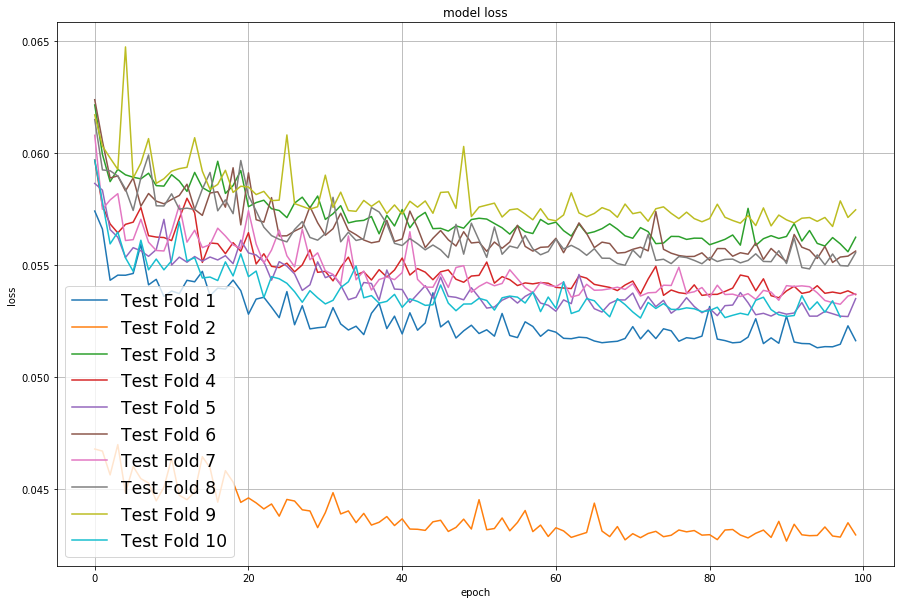

In [71]:
fig, ax = plt.subplots(1,figsize=(15,10))
list_t = []
for i in range(10):
    plt.plot(trn_desc[i].history['val_loss'])
    #plt.plot(T[i].history['val_loss'])
    list_t.append('Test Fold %.f'%(i+1))
    plt.legend(list_t, loc='best',fontsize = 'xx-large')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.grid()
plt.show()

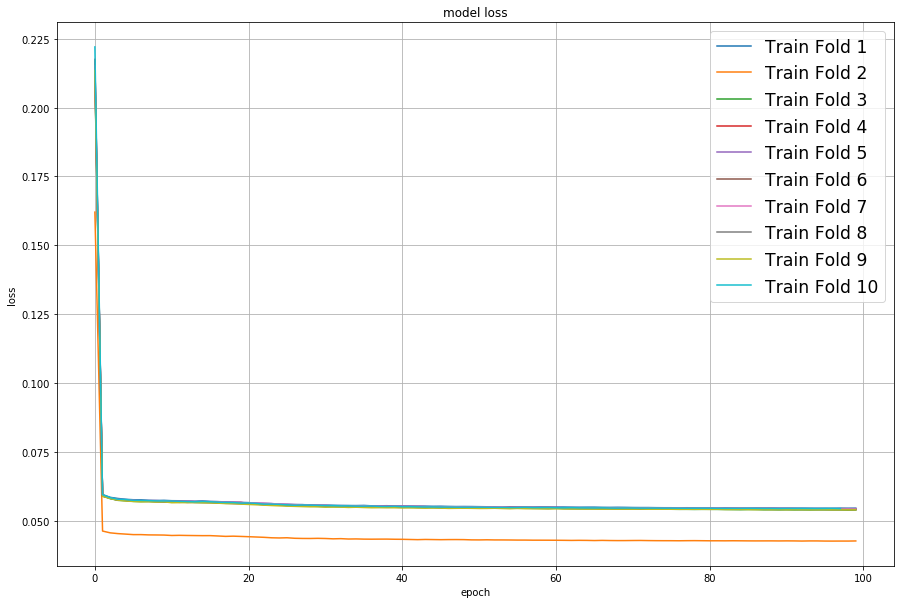

In [74]:
fig, ax = plt.subplots(1,figsize=(15,10))
list_t = []
for i in range(10):
    plt.plot(trn_desc[i].history['loss'])
    #plt.plot(T[i].history['val_loss'])
    list_t.append('Train Fold %.f'%(i+1))
    plt.legend(list_t, loc='best',fontsize = 'xx-large')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.grid()
plt.show()

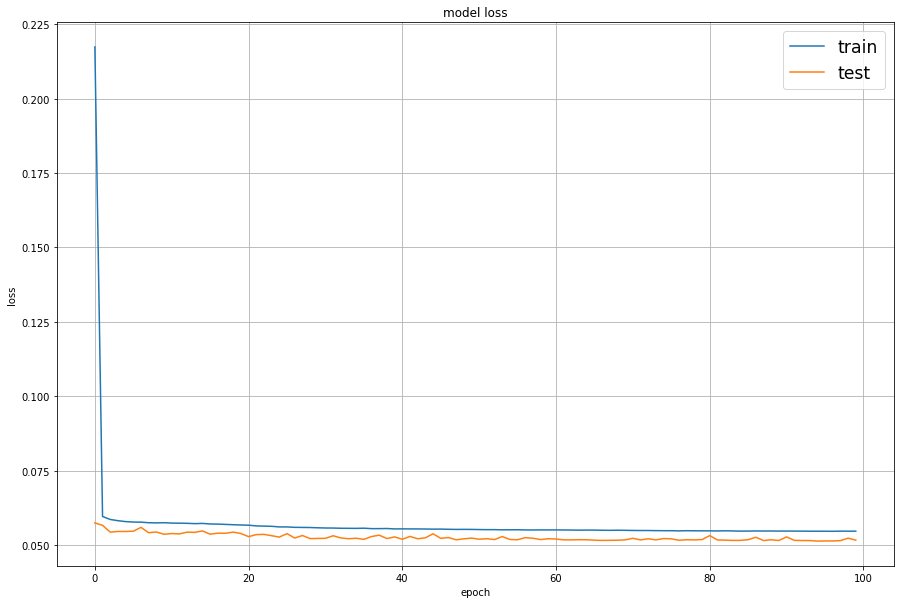

In [76]:
fig, ax = plt.subplots(1,figsize=(15,10))
plt.plot(trn_desc[0].history['loss'])
plt.plot(trn_desc[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right',fontsize = 'xx-large')
plt.grid()
plt.show()

In [10]:
# Get the NN output with all envents

NN_output = estimator[0].predict(norm_all_data, batch_size=8, verbose=0)

print NN_output

[[ 1.38175988]
 [ 1.37261868]
 [ 2.19923306]
 ..., 
 [ 0.79552293]
 [ 2.2156601 ]
 [ 1.26256919]]


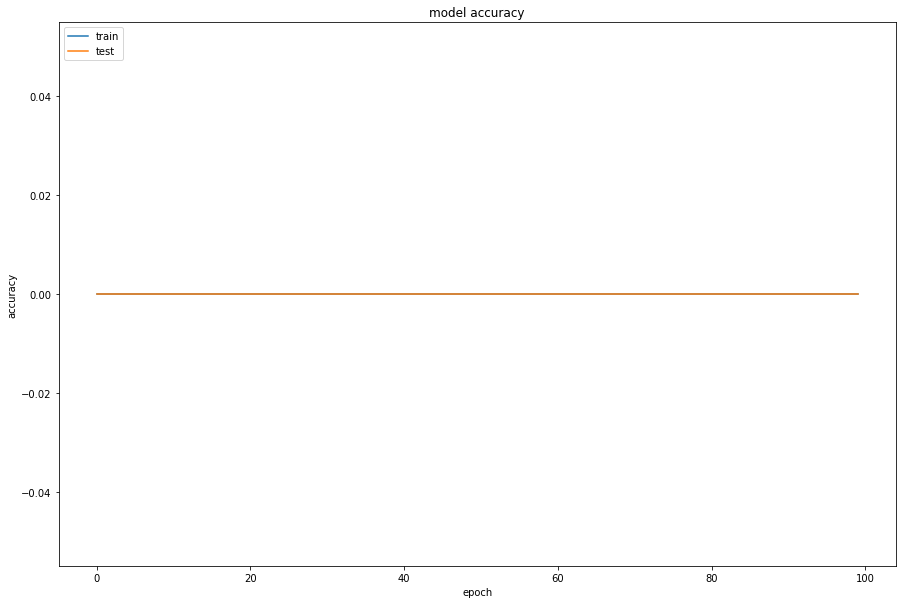

In [14]:
import matplotlib.pyplot as plt
import numpy

fig, ax = plt.subplots(1,figsize=(15,10))
plt.plot(init_trn_desc.history['acc'])
plt.plot(init_trn_desc.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

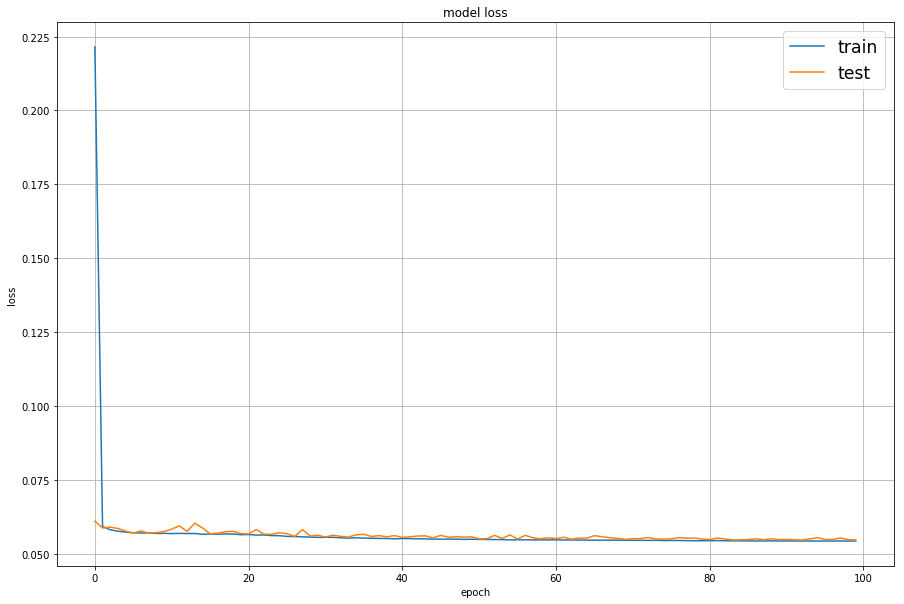

In [20]:
fig, ax = plt.subplots(1,figsize=(15,10))
plt.plot(init_trn_desc.history['loss'])
plt.plot(init_trn_desc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right',fontsize = 'xx-large')
plt.grid()
plt.show()

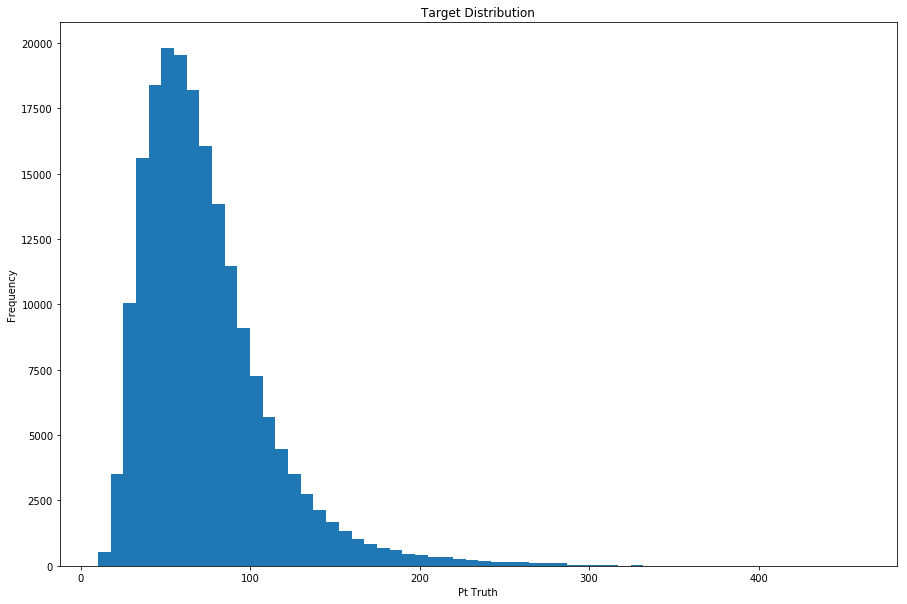

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(15,10))
plt.hist(data_target, 60)
plt.title("Target Distribution")
plt.xlabel("Pt Truth")
plt.ylabel("Frequency")
plt.show()

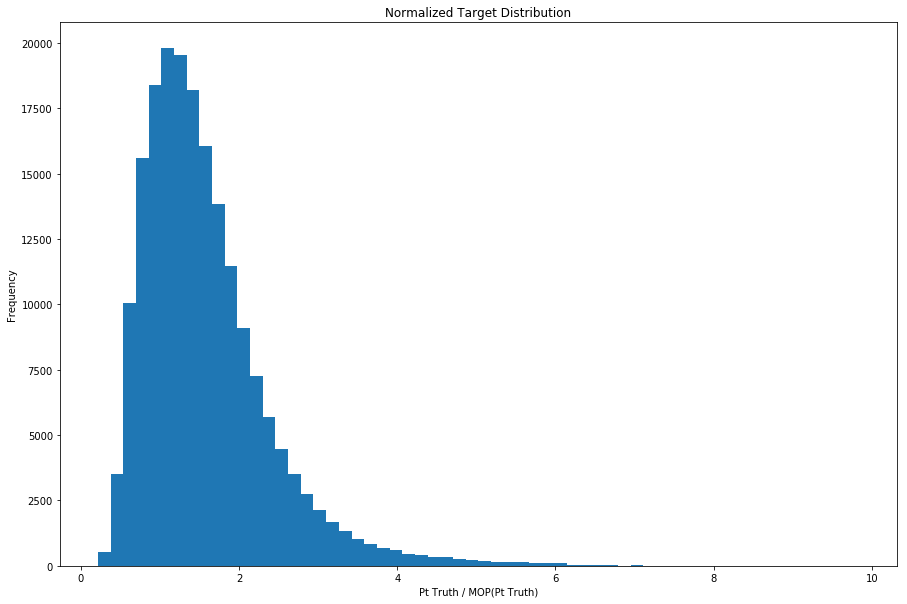

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(15,10))
plt.hist(norm_target, 60)
plt.title("Normalized Target Distribution")
plt.xlabel("Pt Truth / MOP(Pt Truth)")
plt.ylabel("Frequency")
plt.show()

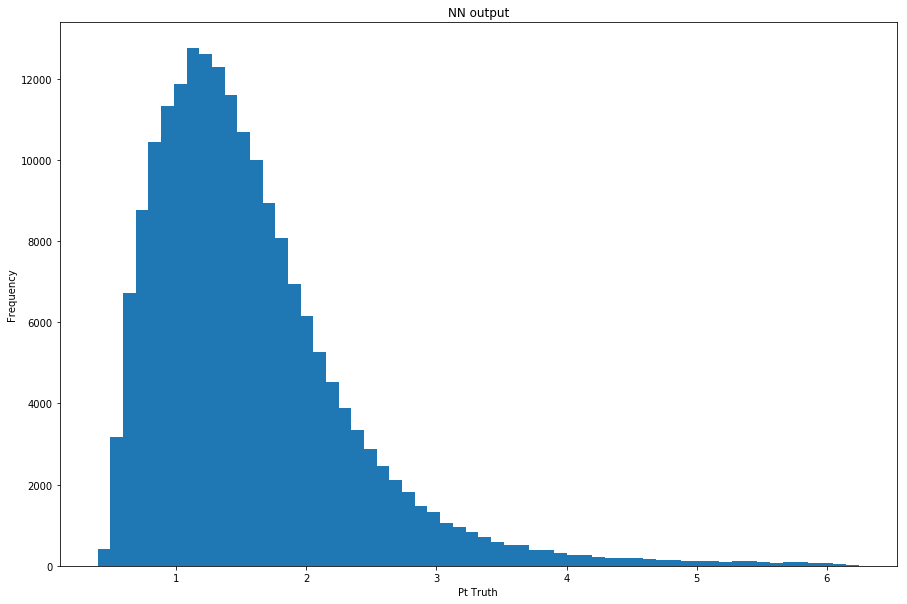

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(15,10))
plt.hist(NN_output, 60)
plt.title("NN output")
plt.xlabel("Pt Truth")
plt.ylabel("Frequency")
plt.show()

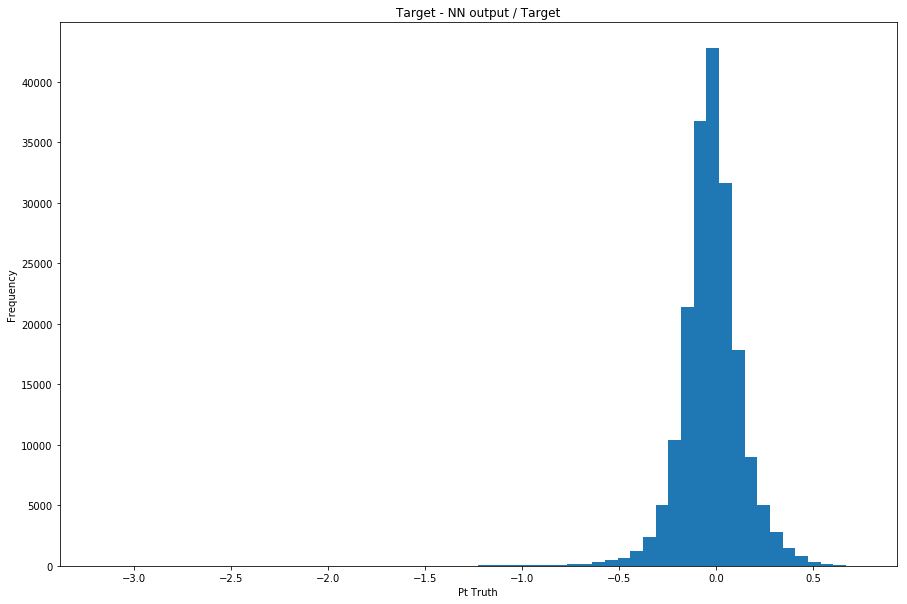

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,figsize=(15,10))
plt.hist((norm_target - NN_output)/norm_target, 60)
plt.title("Target - NN output / Target")
plt.xlabel("Pt Truth")
plt.ylabel("Frequency")
plt.show()

In [ ]:
NN_output_noNorm = NN_output * MOP
np.save(output+"/"+"CorFactors.npy", NN_output_noNorm)
print NN_output_noNorm